# "Conventional" Models

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [19]:
data = pd.read_csv("../data/final/preprocessed.csv", index_col=[0])

# Also MinMax-scaling what will be target; but saving orig. min and
#  max so we can rescale later:
omin, omax = data["net_migration"].min(), data["net_migration"].max()
data["net_migration"] = minmax_scale(data["net_migration"])

# Drop 2022 & 2023
data = data[data["year"] < 2022]

data = data.sort_values(["iso3", "year"]).reset_index(drop=True)

# Construct outcome
data["net_migration_tp1"] = data.groupby(by="iso3").shift(-1)["net_migration"]
data = data.dropna(subset="net_migration_tp1")

# Features & target:
target = "net_migration_tp1"
features = data.drop(["iso3", "year", target], axis=1).columns.tolist()

In [20]:
def collect_metrics(y: np.array, y_hat: np.array) -> dict:
    metrics = {
        "MSE": mean_squared_error(y, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y, y_hat)),
        "MAE": mean_absolute_error(y, y_hat),
        "R-squared": r2_score(y, y_hat)
    }

    return metrics

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2)

## Two-way fixed-effects OLS w/ lagged dependent variable

$$
y_t = \alpha_i + \gamma_t + \beta X_{i,t-1} + y_{t-1}
$$

* $\alpha_i$: unit fixed-effect
* $\gamma_t$: year fixed-effect
* $X_{i,t-1}$: lagged features
* $y_{t-1}$: lagged dependent variable

In [22]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [23]:
y_hat_test_ols = ols.predict(X_test)
ols_metrics = collect_metrics(y_test, y_hat_test_ols)
ols_metrics

{'MSE': 0.00022695254244339456,
 'RMSE': 0.01506494415666366,
 'MAE': 0.0059031267476880355,
 'R-squared': 0.9260519735202415}

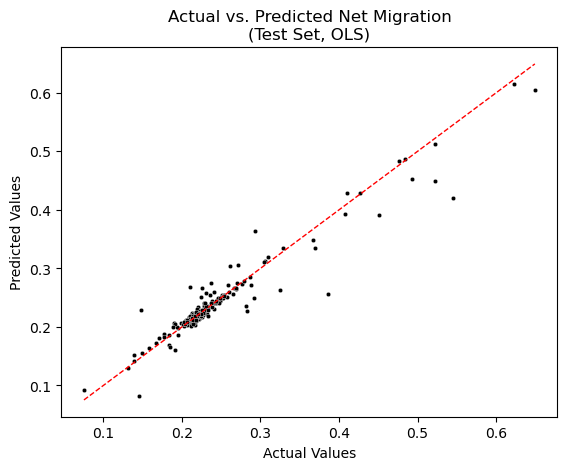

In [31]:
sns.scatterplot(x=y_test, y=y_hat_test_ols, color="black", s=10)
min_val = min(min(y_test), min(y_hat_test_ols))
max_val = max(max(y_test), max(y_hat_test_ols))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Net Migration\n(Test Set, OLS)")
plt.show()

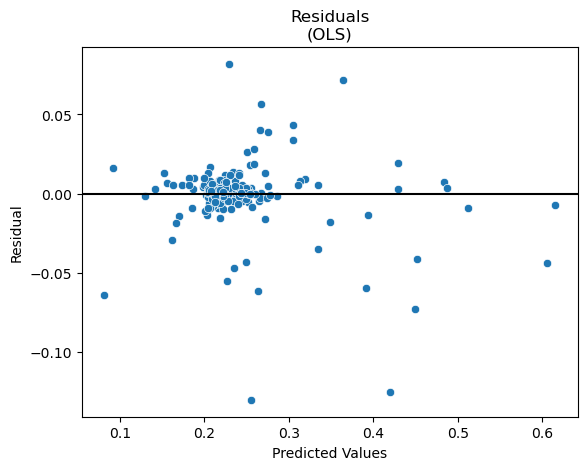

In [37]:
error_ols = y_hat_test_ols - y_test
sns.scatterplot(x=y_hat_test_ols, y=error_ols)
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals\n(OLS)')
plt.show()

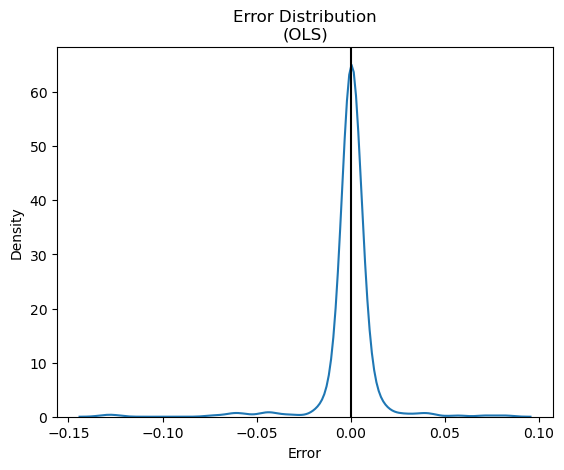

In [43]:
sns.kdeplot(error_ols)
plt.axvline(x=0, color="black")
plt.xlabel('Error')
plt.ylabel('Density')
plt.title('Error Distribution\n(OLS)')
plt.show()

In [95]:
coefs = pd.DataFrame({"feature": features, "coef": ols.coef_})
coefs = coefs.assign(abs_coef=abs(coefs["coef"])).sort_values("abs_coef", ascending=False)
feat_coefs = coefs[~coefs["feature"].isin([*data["iso3"], *[str(y) for y in range(1960, 2024)]])] # drop fixed-effects (one-hot enc. countries & years)

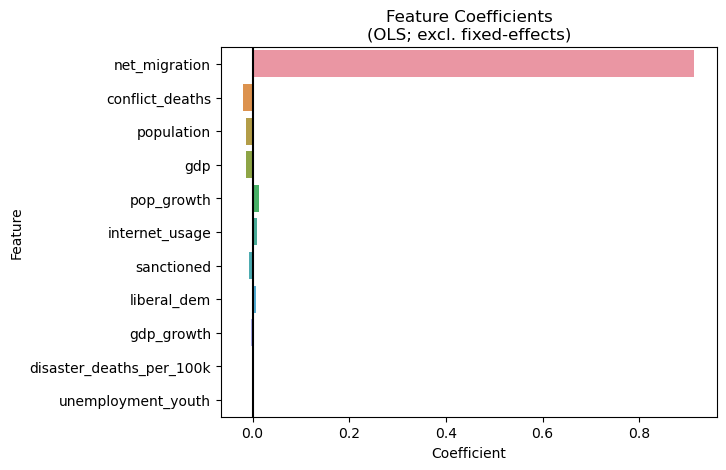

In [96]:
sns.barplot(data=feat_coefs, x="coef", y="feature")
plt.axvline(x=0, color="black")
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients\n(OLS; excl. fixed-effects)')
plt.show()
# ^ Not visualising uncertainty (SEs) given they are not clustered (assumed i.i.d.) and therefore likely biased anyways

## XGBoost-Regressor

In [27]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 300],
    "max_depth": [3, 5],
    "min_child_weight": [1, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring="neg_mean_squared_error",
    verbose=2, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8; tota

In [29]:
xgb_best = grid_search.best_estimator_
y_hat_test_xgb = xgb_best.predict(X_test)

In [30]:
collect_metrics(y_test, y_hat_test_xgb)

{'MSE': 0.00018443001346422065,
 'RMSE': 0.01358050122286437,
 'MAE': 0.005152745659744295,
 'R-squared': 0.9399071040470234}

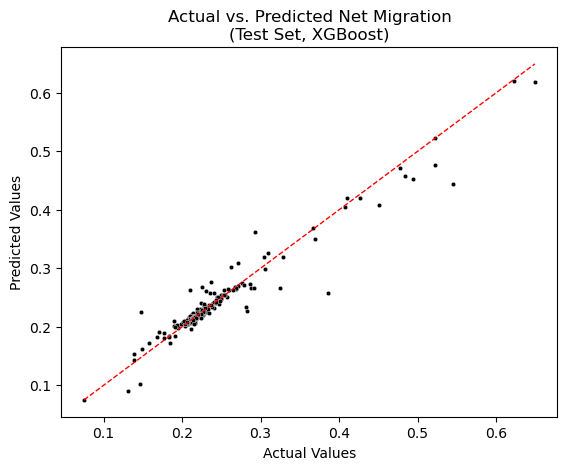

In [32]:
sns.scatterplot(x=y_test, y=y_hat_test_xgb, color="black", s=10)
min_val = min(min(y_test), min(y_hat_test_xgb))
max_val = max(max(y_test), max(y_hat_test_xgb))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Net Migration\n(Test Set, XGBoost)")
plt.show()

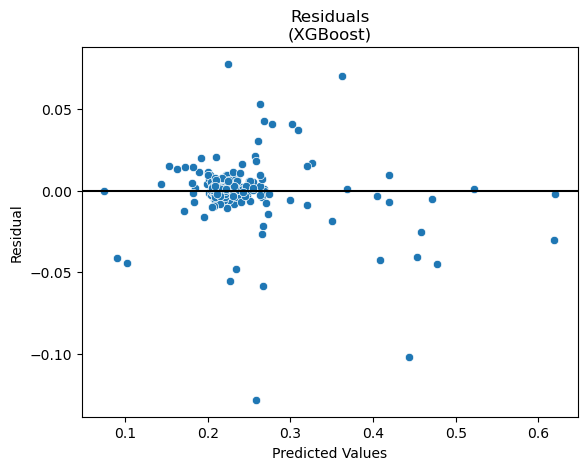

In [36]:
error_xgb = y_hat_test_xgb - y_test
sns.scatterplot(x=y_hat_test_xgb, y=error_xgb)
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals\n(XGBoost)')
plt.show()

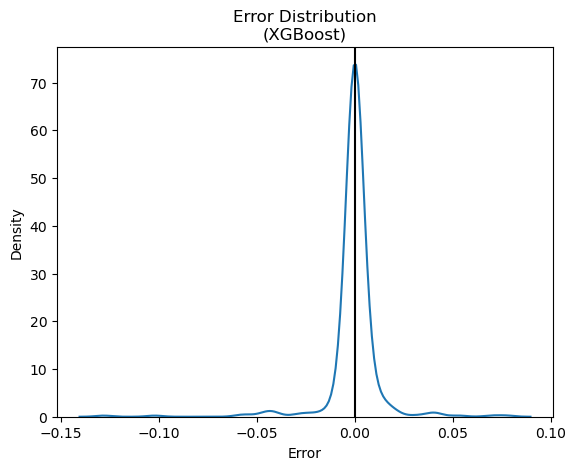

In [45]:
sns.kdeplot(error_xgb)
plt.axvline(x=0, color="black")
plt.xlabel('Error')
plt.ylabel('Density')
plt.title('Error Distribution\n(XGBoost)')
plt.show()

In [51]:
feature_imp = pd.DataFrame({"feature": features, "importance": xgb_best.feature_importances_})

Text(0.5, 1.0, 'Top 10 most important features\n(XGBoost)')

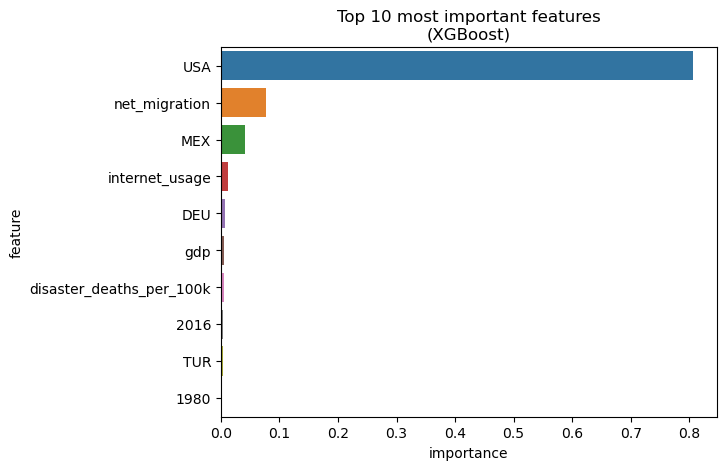

In [87]:
top10_feats = feature_imp.sort_values("importance", ascending=False)[:10]

sns.barplot(
    data=top10_feats,
    x="importance",
    y="feature"
)
plt.title("Top 10 most important features\n(XGBoost)")

# net_migration = net migration in t-1